In [1]:
# !pip install pycuda

In [2]:
import pycuda.autoinit
import pycuda.driver as drv
# from intake.source.cache import display
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from IPython.display import display

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# # Генерация случайного изображения 100x100
# image = np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8)
# img = Image.fromarray(image)
# img.save('image.png')

# # Отображение изображения
# plt.imshow(img)
# plt.show()


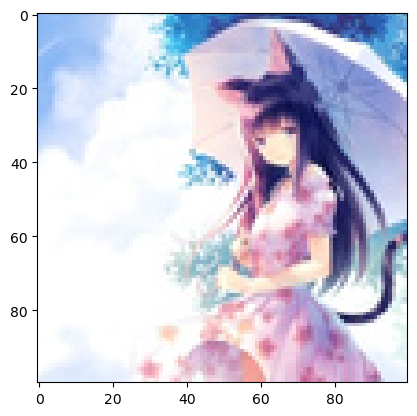

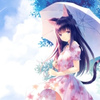

In [4]:
image_for_show = Image.open('./lr1.jpg')

# image_show = Image.fromarray(image_for_show)

plt.imshow(image_for_show)
plt.show()
image_for_show

In [5]:
ker = SourceModule("""
__global__ void krnl(int *red, int *green, int *blue, int array_len) {
    int index = 0;
    int idx = blockDim.x * blockIdx.x + threadIdx.x;
    for (int i = 0; i < array_len / 100; i++) {
        // Вариант 2:
        index = i * 100 + idx;
        red[index] = abs((red[index] - 255) % 256);
        blue[index] = abs((blue[index] - (50 + 10 * 2)) % 256);
        green[index] = abs((green[index] - (15 * 2)) % 256);
    }
}
""")
# Получаем функцию CUDA что нужно поменять, тчобы обрабатывался хвост (длина массива 1000, а блок 64)
krnl = ker.get_function('krnl')

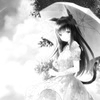

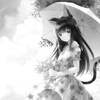

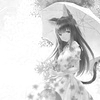

In [6]:
img = Image.open('./lr1.jpg').convert('RGB')
# img_rgba = Image.open('./image.png')
# img = img_rgba.convert('RGB')

data = np.array(img).astype(np.float32)
# data = np.asarray(img, dtype=np.float32) # изображение в массив с переводом в float32

# Разбиваю на каналы по цвету
# red_channel = data[:, :, 0].flatten()
# green_channel = data[:, :, 1].flatten()
# blue_channel = data[:, :, 2].flatten()

red_channel, green_channel, blue_channel = img.split()

# display(red_channel)
# display(green_channel)
# display(blue_channel)

red_channel = np.asarray(red_channel).flatten().astype('uint32')
green_channel = np.asarray(green_channel).flatten().astype('uint32')
blue_channel = np.asarray(blue_channel).flatten().astype('uint32')

red_gpu = gpuarray.to_gpu(red_channel)
green_gpu = gpuarray.to_gpu(green_channel)
blue_gpu = gpuarray.to_gpu(blue_channel)




In [7]:
start_event = drv.Event()
end_event = drv.Event()

In [8]:
block_size = 100
grid_size = (red_channel.size + block_size - 1)


start_event.record()
krnl(red_gpu, green_gpu, blue_gpu, np.int32(red_channel.size), block=(block_size, 1, 1), grid=(1, 1, 1))
end_event.record()


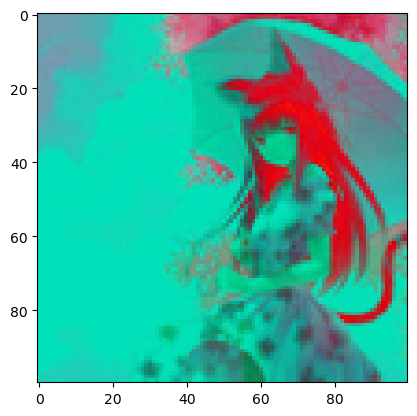

In [9]:
red_result = red_gpu.get()
green_result = green_gpu.get()
blue_result = blue_gpu.get()
end_event.synchronize()

result_image = np.stack((red_result, green_result, blue_result), axis=1).reshape((100, 100, 3))
result_image = np.clip(result_image, 0, 255).astype(np.uint8)


plt.imshow(result_image)
plt.show()

In [10]:
num_arr = 100
streams = []
start_events = []
end_events = []

In [11]:
for repeat in range(num_arr):
    streams.append(drv.Stream())
    start_events.append(start_event)
    end_events.append(end_event)

In [12]:
r = red_channel.reshape(num_arr, int(red_channel.size/num_arr))
g = green_channel.reshape(num_arr, int(green_channel.size/num_arr))
b = blue_channel.reshape(num_arr, int(blue_channel.size/num_arr))

In [13]:
r_gpu_async = []
g_gpu_async = []
b_gpu_async = []
for k in range(num_arr):
    r_gpu_async.append(gpuarray.to_gpu_async(r[k], stream=streams[k]))
    g_gpu_async.append(gpuarray.to_gpu_async(g[k], stream=streams[k]))
    b_gpu_async.append(gpuarray.to_gpu_async(b[k], stream=streams[k]))

In [18]:
for k in range(num_arr):
    start_events[k].record(streams[k])
    krnl(r_gpu_async[k], g_gpu_async[k], b_gpu_async[k], np.int32(r_gpu_async[k].size), block=(100,1,1), grid=(1,1,1), stream=streams[k])
for k in range(num_arr):
    end_events[k].record(streams[k])


In [15]:
r_res_async = []
g_res_async = []
b_res_async = []
for k in range(num_arr):
    r_res_async.append(r_gpu_async[k].get().astype('uint8'))
    g_res_async.append(g_gpu_async[k].get().astype('uint8'))
    b_res_async.append(b_gpu_async[k].get().astype('uint8'))
    # r_res_async[1].size

In [16]:
result_r = np.array(r_res_async).flatten().reshape(100,100)
result_g = np.array(g_res_async).flatten().reshape(100,100)
result_b = np.array(b_res_async).flatten().reshape(100,100)
# display(temp1)
# display(temp2)
# display(temp3)

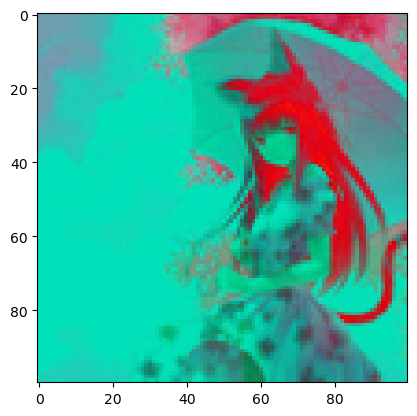

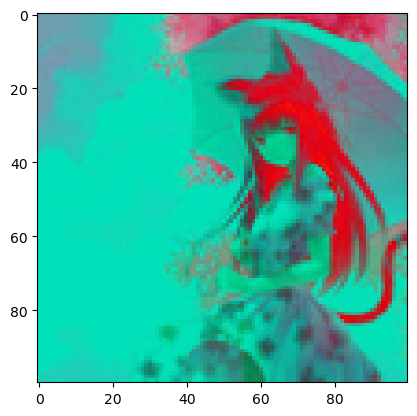

In [17]:
r_restored2 = Image.fromarray(np.array(result_r).astype(np.uint8))
g_restored2 = Image.fromarray(np.array(result_g).astype(np.uint8))
b_restored2 = Image.fromarray(np.array(result_b).astype(np.uint8))
result_img2 = Image.merge('RGB', (r_restored2, g_restored2, b_restored2))
# display(result_img2)
plt.imshow(result_img2)
plt.show()
plt.imshow(result_image)
plt.show()